In [4]:
import os
import time
import pickle
import copy
import numpy as np
from importlib import reload
import ProbeCavityEigenfields as PCE
from ProbeCavityEigenfields import ProbeSpectroscopy as PS
from common import misc
from common.baseclasses import AWA
from common import plotting
from common import numerical_recipes as numrec
from matplotlib import pyplot as plt

# Load probe and encoding from file

In [5]:
probe_name = 'hyperboloid'
#P = PCE.load(probe_name,PCE.Probe)
#Enc = P.gapSpectroscopy(recompute=False,reload=True).Encode(reload=True)
Enc = PCE.load(probe_name,PS.EncodedEigenfields)

Successfully loaded from file "/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/Probe models/(hyperboloid)_EncodedEigenfields.pickle"!


In [6]:
#The stored `Encoding` object should already have this library computed.
#Enc.build_Rmat2D_library(qps=np.logspace(-3, 2, 50))

# Test interpolated RMat

In [7]:
kappas = Enc.kappas
dkappas = Enc.dkappas
Phi0Vecs = Enc.Phi0Vecs[:,:1]
qs=kappas

def get_rps2D(q):

    # Substrate part, then 2D part
    return (1) / (1 - q), \
           (-q) / (1 - q)

def getRmats(qp):

    global qs, Phi0Vecs, dkappas
    rp1_vs_q, rp2_vs_q = get_rps2D(qs / qp)
    R1 = Phi0Vecs.T @ np.diag(dkappas * rp1_vs_q) @ Phi0Vecs
    R2 = Phi0Vecs.T @ np.diag(dkappas * rp2_vs_q) @ Phi0Vecs
    return R1, R2

N=20
qp1s = np.logspace(-2,1,N)
qp1s = np.append(-qp1s[::-1],np.append([0],qp1s))
qp2s = np.logspace(-2,1,N)

In [8]:
eps = -5+5j
I,J=0,0
rs_interp = np.zeros((len(qp1s),len(qp2s)),dtype=complex)
rs_calc = np.zeros((len(qp1s),len(qp2s)),dtype=complex)
for i,qp1 in enumerate(qp1s):
    print(i)
    for j,qp2 in enumerate(qp2s):
        qp=qp1+1j*qp2
        
        Rmat = Enc.interpolate_Rmat2D_from_library(qp, eps)
        rs_interp[i,j]=Rmat[I,J]

        kappa = (eps + 1) / 2
        beta = (eps - 1) / (eps + 1)
        qp_eff = kappa * qp
        RMat_subs,RMat_sigma = getRmats(qp_eff)
        RMat_subs *= beta
        rs_calc[i,j] = (RMat_subs+RMat_sigma)[I,J]

rs_interp = AWA(rs_interp,axes=[qp1s,qp2s],axis_names=['Re(q)','Im(q)'])
rs_calc = AWA(rs_calc,axes=[qp1s,qp2s],axis_names=['Re(q)','Im(q)'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


Text(0.5, 1.0, 'Diff: Re(R), eps=(-5+5j)')

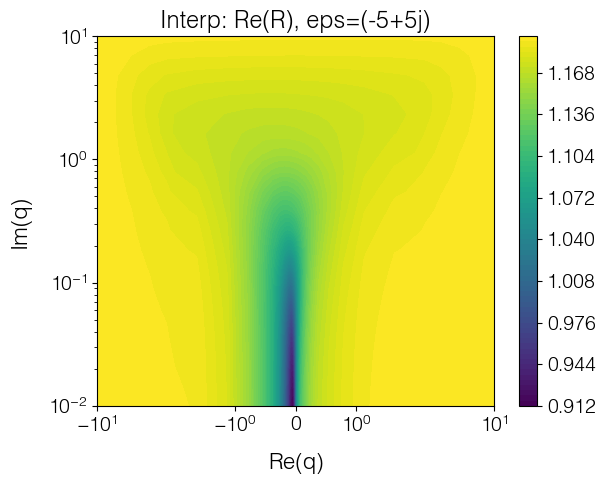

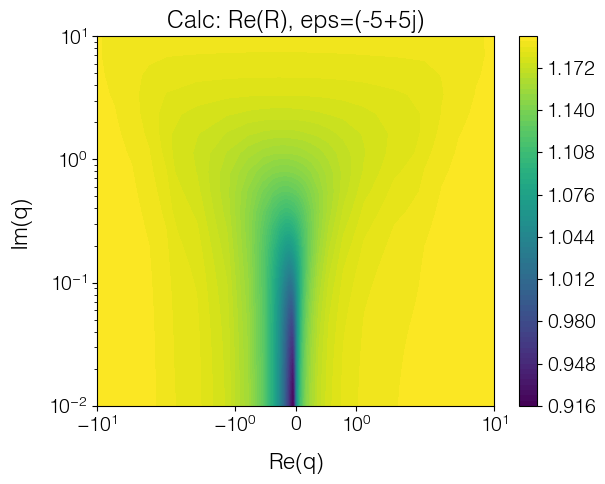

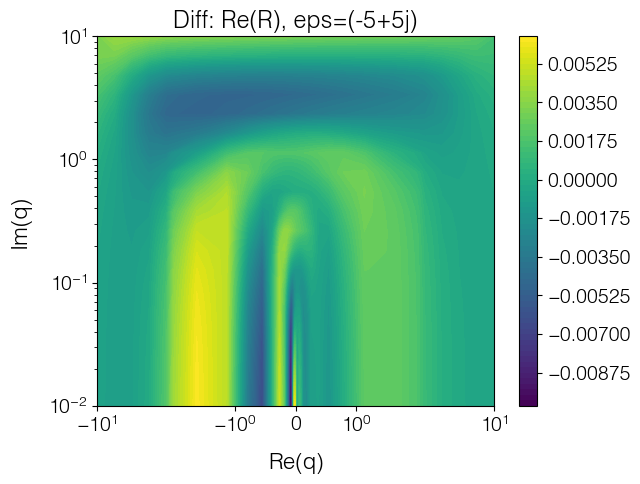

In [10]:
rs_interp.real.plot(plotter=plt.contourf)
plt.gca().set_yscale('log')
plt.gca().set_xscale('symlog')
plt.title('Interp: Re(R), eps=%s'%eps)

plt.figure()
rs_calc.real.plot(plotter=plt.contourf)
plt.gca().set_yscale('log')
plt.gca().set_xscale('symlog')
plt.title('Calc: Re(R), eps=%s'%eps)

plt.figure()
(rs_interp-rs_calc).real.plot(plotter=plt.contourf)
plt.gca().set_yscale('log')
plt.gca().set_xscale('symlog')
plt.title('Diff: Re(R), eps=%s'%eps)

# Practice computing some spectra for different $q_p$

<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Bi2Se3_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "PMMA_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "sio2_300nm_extracted_epsilon_cone_A=2a.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_230K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "TaS2_eps_30K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "Erik_BSTS_epsilon.pickle"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_295K.csv"...
<material_types.TabulatedMaterialFromFile.__init__>:
	Loading tabulated material data from file "VO2_360K.csv"...
<material_types.Ta

Text(0.5, 1.0, 'Scattered field (abs.)')

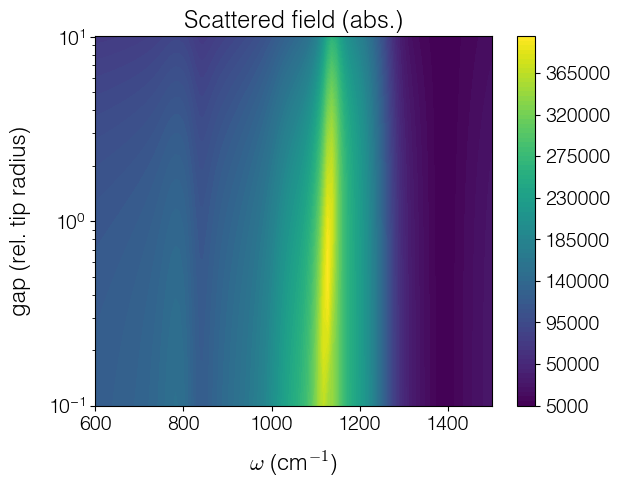

In [11]:
# Using the library, we can rapidly compute near-field contrast of 2D material on any substrate.
# Choose silicon oxide permittivity as our substrate.
from NearFieldOptics import Materials as M
freqs = np.linspace(600,1500,100)
epss = M.SiO2_300nm.epsilon(freqs)

# Decide at what tip-sample gaps we will compute scattered field.  This scattered field E vs. gap = "approach curve."
zmin=.1; A=5 # minimum approach height, and tapping amplitude (= 5 x tip radius ~ 100 nm)
at_gaps = np.linspace(zmin,zmin+2*A,100)

# Choose many hypothetical values of plasma momentum `qp` of 2D layer.  Compute scattered field at all gaps.
Sns={}
for qp in np.logspace(-3,1,5):
    print('qp=%s'%qp)

    #For this value of `qp`, compute a series of approach curves at different permittivity values of substrate.
    erads = []
    for i,eps in enumerate(epss):
        p = i/len(epss)*100
        print('Progress=%i%%'%p,end='\r',flush=True)
        R0 = Enc.interpolate_Rmat2D_from_library(qp, eps)
        erad = Enc.EradVsGap(at_gaps, freq=Enc.get_probe().get_freq(), RMat0=R0)
        #erad = Enc.EradVsGap(at_gaps, freq=Enc.get_probe().get_freq(), rp=(eps-1)/(eps+1))
        erads.append(erad)

    # Demodulate the series of approach curves to make a single spectrum for each tapping harmonic.
    # All harmonics will be in `Sns[qp]`.
    erads = AWA(erads,axes=[freqs,at_gaps],axis_names=[r'$\omega$ (cm$^{-1}$)',
                                                       'gap (rel. tip radius)'])
    #np.abs(erads).plot()
    Sns[qp] = PCE.demodulate(erads.T)

# You can see what approach curve looks like for one of these, at all frequencies.
np.abs(erads).plot(plotter=plt.contourf)
plt.gca().set_yscale('log')
plt.title('Scattered field (abs.)')

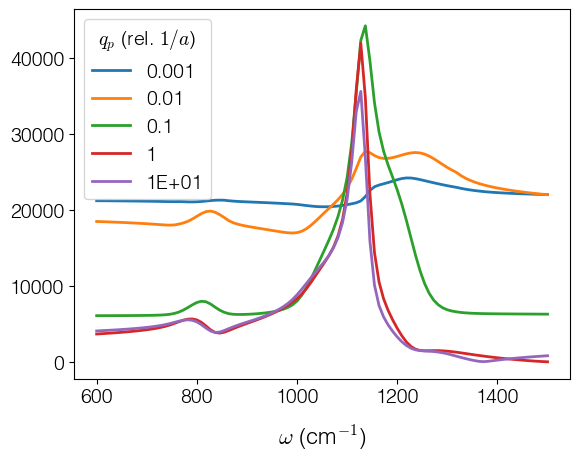

In [12]:
# Plot the spectrum for each choice of `qp`.
# Decreasing `qp` means the 2D material gets more metallic.
harmonic = 2
qps = sorted(list(Sns.keys()))
for qp in qps:
    np.abs(Sns[qp].cslice[harmonic]).plot(label='%1.1G'%qp)
plt.legend(title='$q_p$ (rel. $1/a$)')

# Inversion of $q_p$

## Inversion tools

In [13]:
# These are a bunch of tools to accelerate using the library to solve the inverse problem.
from scipy.optimize import leastsq

# This will quickly do all the forward simulation that we implemented by hand in previous cell.
class S_vs_qp_predictor(object):

    def __init__(self, Enc,
                 zmin=.1, A=2, Nts=24,
                 harmonic=2,
                Sref=1):

        # Demodulation quadrature nodes (and weights) in time
        self.ts,self.dts=numrec.GetQuadrature(N=Nts,xmin=-.5,xmax=0,
                                              quadrature=numrec.GL)
        self.kernel = np.cos(2*np.pi*harmonic*self.ts) * self.dts
        self.kernel -= np.mean(self.kernel)

        # Corresponding gap heights
        self.at_gaps = zmin + A*(1+np.cos(2*np.pi*self.ts))
        self.freq = Enc.get_probe().get_freq()
        self.Enc = Enc
        self.Sref = Sref # Signal value to which we pretend data were referenced

    def massage_arg(self,arg): #Assume argument must have positive imaginary

        return arg.real + 1j*np.abs(arg.imag)

    def __call__(self, qp, eps):

        #Inhibit negative imaginary for qp or eps
        qp = self.massage_arg(qp)
        eps = self.massage_arg(eps)

        # "Lookup" eigenfield scattering matrix
        R0 = self.Enc.interpolate_Rmat2D_from_library(qp, eps)

        # Compute scattered field at gap heights; output raw array
        erad_vs_gap = self.Enc.EradVsGap(self.at_gaps, freq=self.freq,
                                         RMat0=R0, as_AWA = False )

        # here is the demodulation! at quadrature nodes
        erad_vs_gap = np.array(erad_vs_gap)
        Sn = 4 * np.sum( self.kernel * erad_vs_gap, axis=0)

        return complex(Sn/self.Sref)
        
def residual(args,S_target_r,S_target_i,
             S_predictor,eps,exp=1):

    S_target = S_target_r+1j*S_target_i
    qpr,qpi = args
    qp = qpr+1j*qpi

    diff = S_target - S_predictor(qp,eps)
    diffr = float(diff.real)
    diffi = float(diff.imag)

    # Minimize absolute value of imaginary and real differences separately
    return np.abs(np.array((diffr,diffi)))**exp

## Practice inversion at one permittivity

In [14]:
# Parameters for probe model
harmonic = 2
zmin = 0.1 # distance of closest approach of probe to sample ( units of tip radius)
A=4 # tapping amplitude (units of tip radius)

# Something we knew about our measurement - the substrate permittivity
eps = 2
# The ground truth
qp_actual = .5+.1j

# The simulated signal
# Reference signal from high permittivity (gold)
Sref = Enc.EradDemodulated2DFromLibrary(qp=1e3,eps=1e3,zmin=zmin,A=A)['Sn'][harmonic]
S_predictor = S_vs_qp_predictor(Enc,
                               harmonic=harmonic,Nts=48,
                               A=A,zmin=zmin,
                               Sref=Sref) # Predictor will predict normalized signal, using our reference signal
S_target = S_predictor(qp_actual,eps) # suppose this is were our measurement

# Least squares solution for inversion
t0 = time.time()
exp=1
qp_0 = (.1,.1) # starting guess for `qp`
result = leastsq(residual,qp_0, args=(S_target.real,S_target.imag,
                                    S_predictor,eps,exp),
                 factor=0.1,full_output=False, xtol = 1e-20, ftol=1e-20)[0]

print('Elapsed:',time.time()-t0)
qp_predicted = result[0]+1j*result[1]

print('qp Actual:',qp_actual)
print('qp Predicted:',qp_predicted)

print('S actual:',S_predictor(qp_actual,eps))
print('S predicted:',S_predictor(qp_predicted,eps))



/Users/alexandersmcleod/tools/python/common/numerical_recipes.py:209: DeprecationWarning: scipy.ifft is deprecated and will be removed in SciPy 2.0.0, use scipy.fft.ifft instead
  F = np.real(ifft(V, n=None, axis=0))


	Computing at freq=1.600E-03...
<ProbeSpectroscopy.EncodedEigenfields.EradSpectrumDemodulated>:
	Demodulating...
		Time elapsed: 0.07477021217346191
Elapsed: 0.30216312408447266
qp Actual: (0.5+0.1j)
qp Predicted: (0.499999999954135+0.10000000002038913j)
S actual: (0.04669290503609282+0.018243299559967213j)
S predicted: (0.04669290503988747+0.01824329957249407j)


## Inversion at a series of known permittivities $\varepsilon(\omega)$, to obtain spectrum $q_p(\omega)$

	Computing at freq=1.600E-03...
<ProbeSpectroscopy.EncodedEigenfields.EradSpectrumDemodulated>:
	Demodulating...
		Time elapsed: 0.01102304458618164


<>:58: DeprecationWarning: invalid escape sequence \i
<>:58: DeprecationWarning: invalid escape sequence \i
/var/folders/67/32mwwcnj2pl1mtqhfc7mzlz80000gn/T/ipykernel_4212/3882142224.py:58: DeprecationWarning: invalid escape sequence \i
  plt.plot(freqs,np.abs(S0),label='substrate ($q_p = \infty$)')


Text(0, 0.5, '$q_p \\cdot a$')

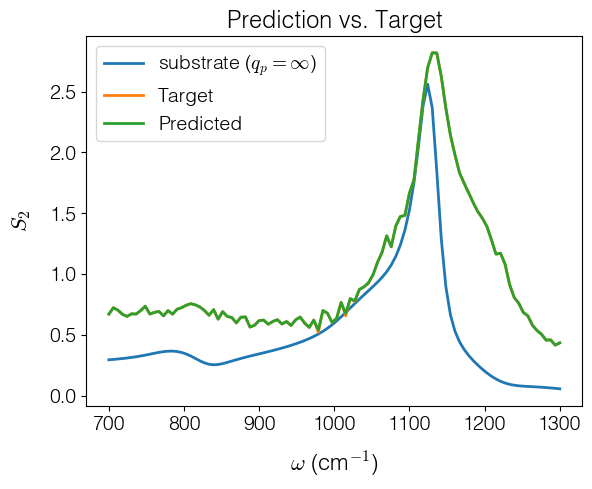

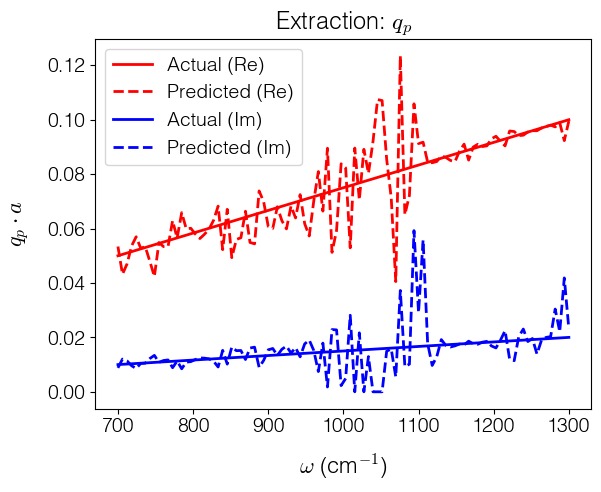

In [15]:
#--- Decide the underlying substrate material we will simulate
freqs = np.linspace(700,1300,100)
epss = M.SiO2_300nm.epsilon(freqs) # Our `known` permittivities of substrate at our energies of measurement

#--- Describe parameters of the measurement, and the reference signal
harmonic = 2
zmin = 0.1
A=4
Sref = Enc.EradDemodulated2DFromLibrary(qp=1e3,eps=1e3,zmin=zmin,A=A)['Sn'][harmonic]
# This is the signal from any good metal (gold)

#--- Build predictor, expecting same measurement parameters and reference
S_predictor = S_vs_qp_predictor(Enc,
                               harmonic=harmonic,Nts=48,
                               A=A,zmin=zmin,
                               Sref=Sref)
S0 = [S_predictor(qp=1e3,eps=eps) \
      for eps in epss] # Predict spectrum of underlying substrate
S0 = np.array(S0)

#--- Build ground truth qp values, and simulate the measurement
simulate_target = True
if simulate_target:
    Q=5 # plasmonic quality factor
    qps_actual = np.linspace(.05,0.1,len(freqs))*(1+1j/Q)
    S_targets = [S_predictor(qp_actual,eps) for qp_actual,eps in zip(qps_actual,epss)]
    S_targets = np.array(S_targets) # Model will try to reproduce this 'target'
    
    #--- Add noise to the simulated values (obviously remove this for actual data)
    n=0.05
    S_targets += n*np.random.randn(len(freqs))
else:
    # Here put our measurement: numeric complex values of the measured normalized signal
    pass

#--- Try to predict a signal matching target at each frequency
exp=1
qps_pred = []
qp_pred = 0.1+.1j
for freq,eps,S_target in zip(freqs,epss,S_targets):
    t0 = time.time()
    x0 = (qp_pred.real,qp_pred.imag)
    result = leastsq(residual,x0, args=(S_target.real,S_target.imag,
                                        S_predictor,eps,exp),
                     factor=0.1,full_output=False, xtol = 1e-20, ftol=1e-20)[0]
    print('freq=%1.2f'%freq,'; Elapsed: %1.3f'%(time.time()-t0),
          end='\r',flush=True)
    qp_pred = result[0]+1j*result[1]
    qps_pred.append(qp_pred)
# coerce to what predictor "sees" during optimization
qps_pred = S_predictor.massage_arg(np.array(qps_pred))

#--- See what spectrum is implied by the predicted qp values
S_preds = [S_predictor(qp_pred,eps) for qp_pred,eps in zip(qps_pred,epss)]

#--- Plot signals
plt.figure()
plt.plot(freqs,np.abs(S0),label='substrate ($q_p = \infty$)')
plt.plot(freqs,np.abs(S_targets),label='Target')
plt.plot(freqs,np.abs(S_preds),label='Predicted')
plt.legend()
plt.title('Prediction vs. Target')
plt.xlabel(r'$\omega$ (cm$^{-1}$)')
plt.ylabel(r'$S_%i$'%harmonic)

#--- Plot predicted qp vs. ground truth
plt.figure()
plt.plot(freqs,qps_actual.real,label='Actual (Re)',color='r')
plt.plot(freqs,qps_pred.real,label='Predicted (Re)',color='r',ls='--')
plt.plot(freqs,qps_actual.imag,label='Actual (Im)',color='b')
plt.plot(freqs,qps_pred.imag,label='Predicted (Im)',color='b',ls='--')
plt.legend()
plt.title(r'Extraction: $q_p$')
plt.xlabel(r'$\omega$ (cm$^{-1}$)')
plt.ylabel(r'$q_p \cdot a$')